# Word2Vec

Again, gensim is simpler

In [1]:
import collections
import os
import math
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

/home/alvaro/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_url = "http://mattmahoney.net/dc/text8.zip"

In [3]:
def fetch_word_data():
    
    #zip file needed 
    data_dir = "word2vec_data/words"
    zip_path = os.path.join(data_dir, "words.zip")
    
    # Get the data from the zip file
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source
    return data.decode("ascii").split()

In [4]:
words = fetch_word_data()

In [5]:
len(words)

17005207

In [6]:
words[:40]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to']

In [7]:
for w in words[9000:9040]:
    print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [8]:
from collections import Counter

In [9]:
my_list = ["one", "two", "two"]
Counter(my_list)

Counter({'one': 1, 'two': 2})

Pretty straightforward

In [10]:
def create_counts(vocab_size=50000):
    
    vocab = [] + Counter(words).most_common(vocab_size) #grab the most common 50,000 words
    
    vocab = np.array([word for word, _ in vocab]) # disregard the count
    
    dictionary = {word:code for code, word in enumerate(vocab)}
    
    data = np.array([dictionary.get(word, 0) for word in words])
    
    return data, vocab

In [11]:
data, vocabulary = create_counts()

In [12]:
data.shape

(17005207,)

In [13]:
vocabulary.shape

(50000,)

In [14]:
words[100]

'interpretations'

In [15]:
data[100]

4186

In [51]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 # skip_window target skip_window
    buffer = collections.deque(maxlen=span)
    
    if data_index + span > len(data):
        data_index = 0
    
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i + num_skips + j, 0] = buffer[target]
    
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
    
    # Backtrack a little bit to avoid skipping words in the end of the batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [52]:
# Constants
batch_size = 128
embedding_size = 150 # trade-off between information and time to train
skip_window = 1
num_skips = 2

valid_window = 100
valid_size = 16
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64
learning_rate = 0.01

vocabulary_size = 50000

In [53]:
# Placeholder
tf.reset_default_graph()
train_inputs = tf.placeholder(tf.int32, shape=[None])

train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [54]:
# Variables
init_embeddings = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_inputs) # Looks up `ids` in a list of embedding tensors.

In [55]:
# Loss function, Optimizer, Session
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev = 1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
trainer = optimizer.minimize(loss)

In [56]:
# Compute the cosine similarity
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm

valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [57]:
data_index = 0
init = tf.global_variables_initializer()

In [59]:
# Session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)


num_steps = 5000
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict={train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss / 1000
            print("Average loss at step ", step, " is: ", average_loss)
            average_loss = 0
        
        final_embeddings = normalized_embeddings.eval()
        

Average loss at step  0  is:  297.1019287109375
Average loss at step  1000  is:  219.01954719543457
Average loss at step  2000  is:  149.45832154464722
Average loss at step  3000  is:  113.17614328670501
Average loss at step  4000  is:  100.55064768981934


## Visualising

In [60]:
final_embeddings.shape

(50000, 150)

In [61]:
from sklearn.manifold import TSNE

In [79]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [86]:
plot_only = 500
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [87]:
labels = [vocabulary[i] for i in range(plot_only)]

In [88]:
low_dim_embed.shape

(500, 2)

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels)
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy = (x, y),
                     xytext = (5,2),
                     textcoords = 'offset points',
                     ha = 'right',
                     va = 'bottom')

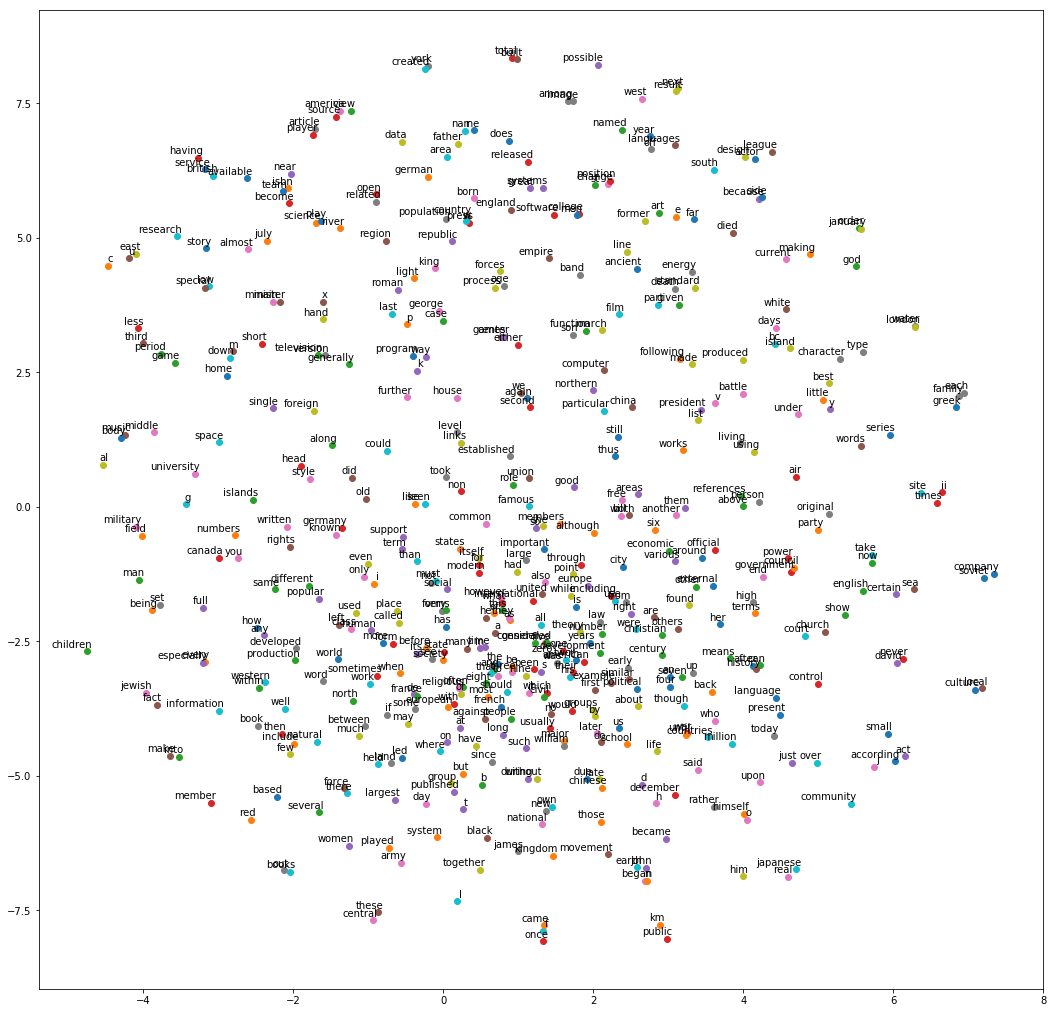

In [91]:
plot_with_labels(low_dim_embed, labels)